# Correlation and Diversification #

George is a trading enthusiast. For several months now, he has been spending a considerable amount of time and money on the stock markets. He enjoys investing in stocks, but he admits he is not an expert. He has made very good money on some investments, but he has also lost money on others. He understands that some of the gains have offset some of the losses... George has discovered the benefits of diversification.

In [39]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Optimization
import statsmodels.api as sm 

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from config import get_tickers
from data_downloader import get_market_data

### Benefits of Diversification ###

In [40]:
tickers = get_tickers(mod="2.1")

tickers

['AMZN', 'MCD', 'WMT']

In [41]:
# Import data
df_returns = pd.DataFrame()

for ticker in tickers:
    df = get_market_data(
        ticker=ticker, 
        start_date='2000-01-01',
        end_date='2025-01-01', 
        returns=True
    )
    
    returns = df['returns'].rename(ticker)
    
    df_returns = pd.concat([df_returns, returns], axis=1)
    
    print(f'Data Ready for {ticker}')

Data Ready for AMZN
Data Ready for MCD
Data Ready for WMT


In [42]:
df_returns

,AMZN,MCD,WMT
2000-01-04 00:00:00,-0.086884,-0.020719,-0.038136
2000-01-05 00:00:00,-0.161039,0.015976,-0.020619
2000-01-06 00:00:00,-0.061914,-0.014366,0.010853
2000-01-07 00:00:00,0.059222,0.025398,0.072845
2000-01-10 00:00:00,-0.005405,0.004691,-0.018416
...,...,...,...
2024-12-24 00:00:00,0.017573,0.009226,0.025462
2024-12-26 00:00:00,-0.008770,0.002751,0.001186
2024-12-27 00:00:00,-0.014641,-0.004011,-0.012253
2024-12-30 00:00:00,-0.011010,-0.013786,-0.011963


In [43]:
# Theoretically, we could use the average as the expected returns (these are daily returns)
expected_returns = df_returns.mean() * 252
expected_returns.name = 'annualized_returns'

expected_returns

AMZN    0.156047
MCD     0.104197
WMT     0.073747
Name: annualized_returns, dtype: float64

In [44]:
# The volatility is calculated with the standard deviations (also annualized volatility)
volatility = df_returns.dropna().std() * np.sqrt(252)
volatility.name = 'annualized_volatility'

volatility

AMZN    0.487978
MCD     0.228802
WMT     0.233172
Name: annualized_volatility, dtype: float64

In [45]:
# Covariance Matrix
cov_matrix = df_returns.dropna().cov() * 252

cov_matrix

,AMZN,MCD,WMT
AMZN,0.238122,0.023465,0.026171
MCD,0.023465,0.052350,0.017579
WMT,0.026171,0.017579,0.054369


In [46]:
# Create the Equal-Weighted Portfolio
n_assets = len(df_returns.columns)
weights = np.array([1/n_assets] * n_assets)  # Equal weights

weights

array([0.33333333, 0.33333333, 0.33333333])

In [47]:
# Portfolio expected return
portfolio_return = np.dot(weights, expected_returns)

# Portfolio variance and volatility
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility = np.sqrt(portfolio_variance)

print("\nPortfolio Expected Return:", portfolio_return)
print("Portfolio Volatility:", portfolio_volatility)


Portfolio Expected Return: 0.11133029926424413
Portfolio Volatility: 0.23076495139070077


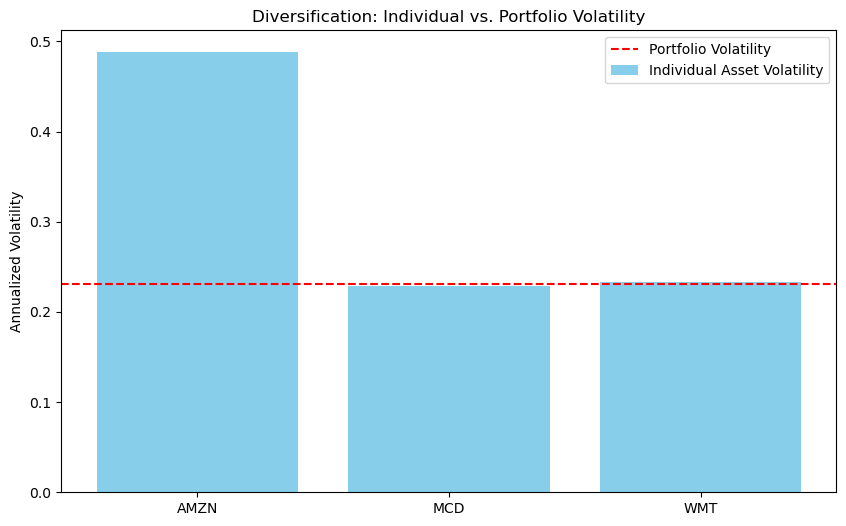

In [48]:
# Plot the Standard Deviations
plt.figure(figsize=(10, 6))
plt.bar(df_returns.columns, volatility, color='skyblue', label='Individual Asset Volatility')
plt.axhline(y=portfolio_volatility, color='red', linestyle='--', label='Portfolio Volatility')
plt.ylabel('Annualized Volatility')
plt.title('Diversification: Individual vs. Portfolio Volatility')
plt.legend()
plt.show()

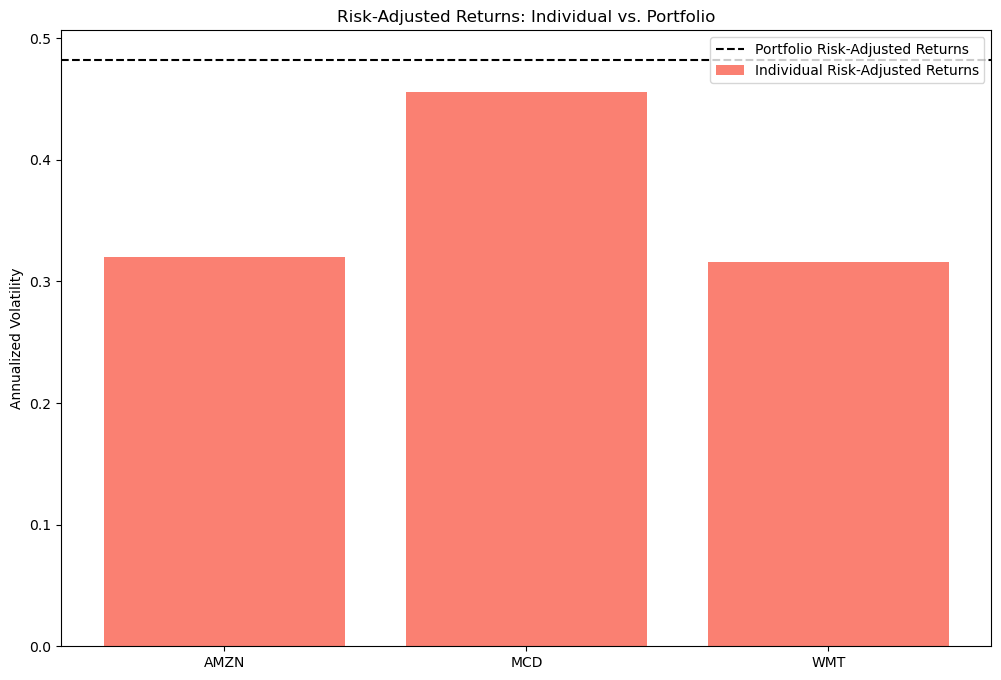

In [49]:
# Efficiency Ratios
eff_ratios = expected_returns/volatility
portafolio_effciency = portfolio_return/portfolio_volatility

plt.figure(figsize=(12, 8))
plt.bar(df_returns.columns, eff_ratios, color='salmon', label='Individual Risk-Adjusted Returns')
plt.axhline(y=portafolio_effciency, color='black', linestyle='--', label='Portfolio Risk-Adjusted Returns')
plt.ylabel('Annualized Volatility')
plt.title('Risk-Adjusted Returns: Individual vs. Portfolio')
plt.legend()
plt.show()

In [50]:
# Adjusted Returns
print(f"Portfolio Risk-Adjusted Returns: {portafolio_effciency}")
print(f"Stocks Risk-Adjusted Returns:\n{eff_ratios}")

Portfolio Risk-Adjusted Returns: 0.482440243170872
Stocks Risk-Adjusted Returns:
AMZN    0.319783
MCD     0.455401
WMT     0.316279
dtype: float64


### The Correlation ###

In [51]:
# Correlation is the Scale of Covariance [-1, 1]
pearson = df_returns.corr()

pearson

,AMZN,MCD,WMT
AMZN,1.000000,0.210163,0.230013
MCD,0.210163,1.000000,0.329504
WMT,0.230013,0.329504,1.000000


In [52]:
# Non-Linear Correlations
spearman = df_returns.corr(method='spearman')

spearman

,AMZN,MCD,WMT
AMZN,1.000000,0.267527,0.266507
MCD,0.267527,1.000000,0.344531
WMT,0.266507,0.344531,1.000000


In [53]:
# Let us get the Residual Returns (we show how to obtain them in Module 4)
res_returns = pd.read_csv(r'..\additional_data\capm_residual_returns.csv')
res_returns = res_returns.rename(columns={'Unnamed: 0': 'Date'})

res_returns = res_returns.set_index('Date')
res_returns.index = pd.to_datetime(res_returns.index)

# Just the stocks we need
res_returns = res_returns[df_returns.columns]
res_returns

,AMZN,MCD,WMT
Date,,,
2000-01-03,0.177558,-0.011249,-0.020923
2000-01-04,-0.016235,0.003431,0.013974
2000-01-05,-0.164298,0.014715,-0.023119
2000-01-06,-0.063467,-0.015026,0.009640
2000-01-07,0.011454,0.008445,0.035859
...,...,...,...
2024-12-24,0.000603,0.005297,0.021982
2024-12-26,-0.008069,0.002811,0.001224
2024-12-27,0.002669,-0.000207,-0.008741


In [54]:
res_returns.corr()

,AMZN,MCD,WMT
AMZN,1.000000,-0.046080,-0.048765
MCD,-0.046080,1.000000,0.102345
WMT,-0.048765,0.102345,1.000000


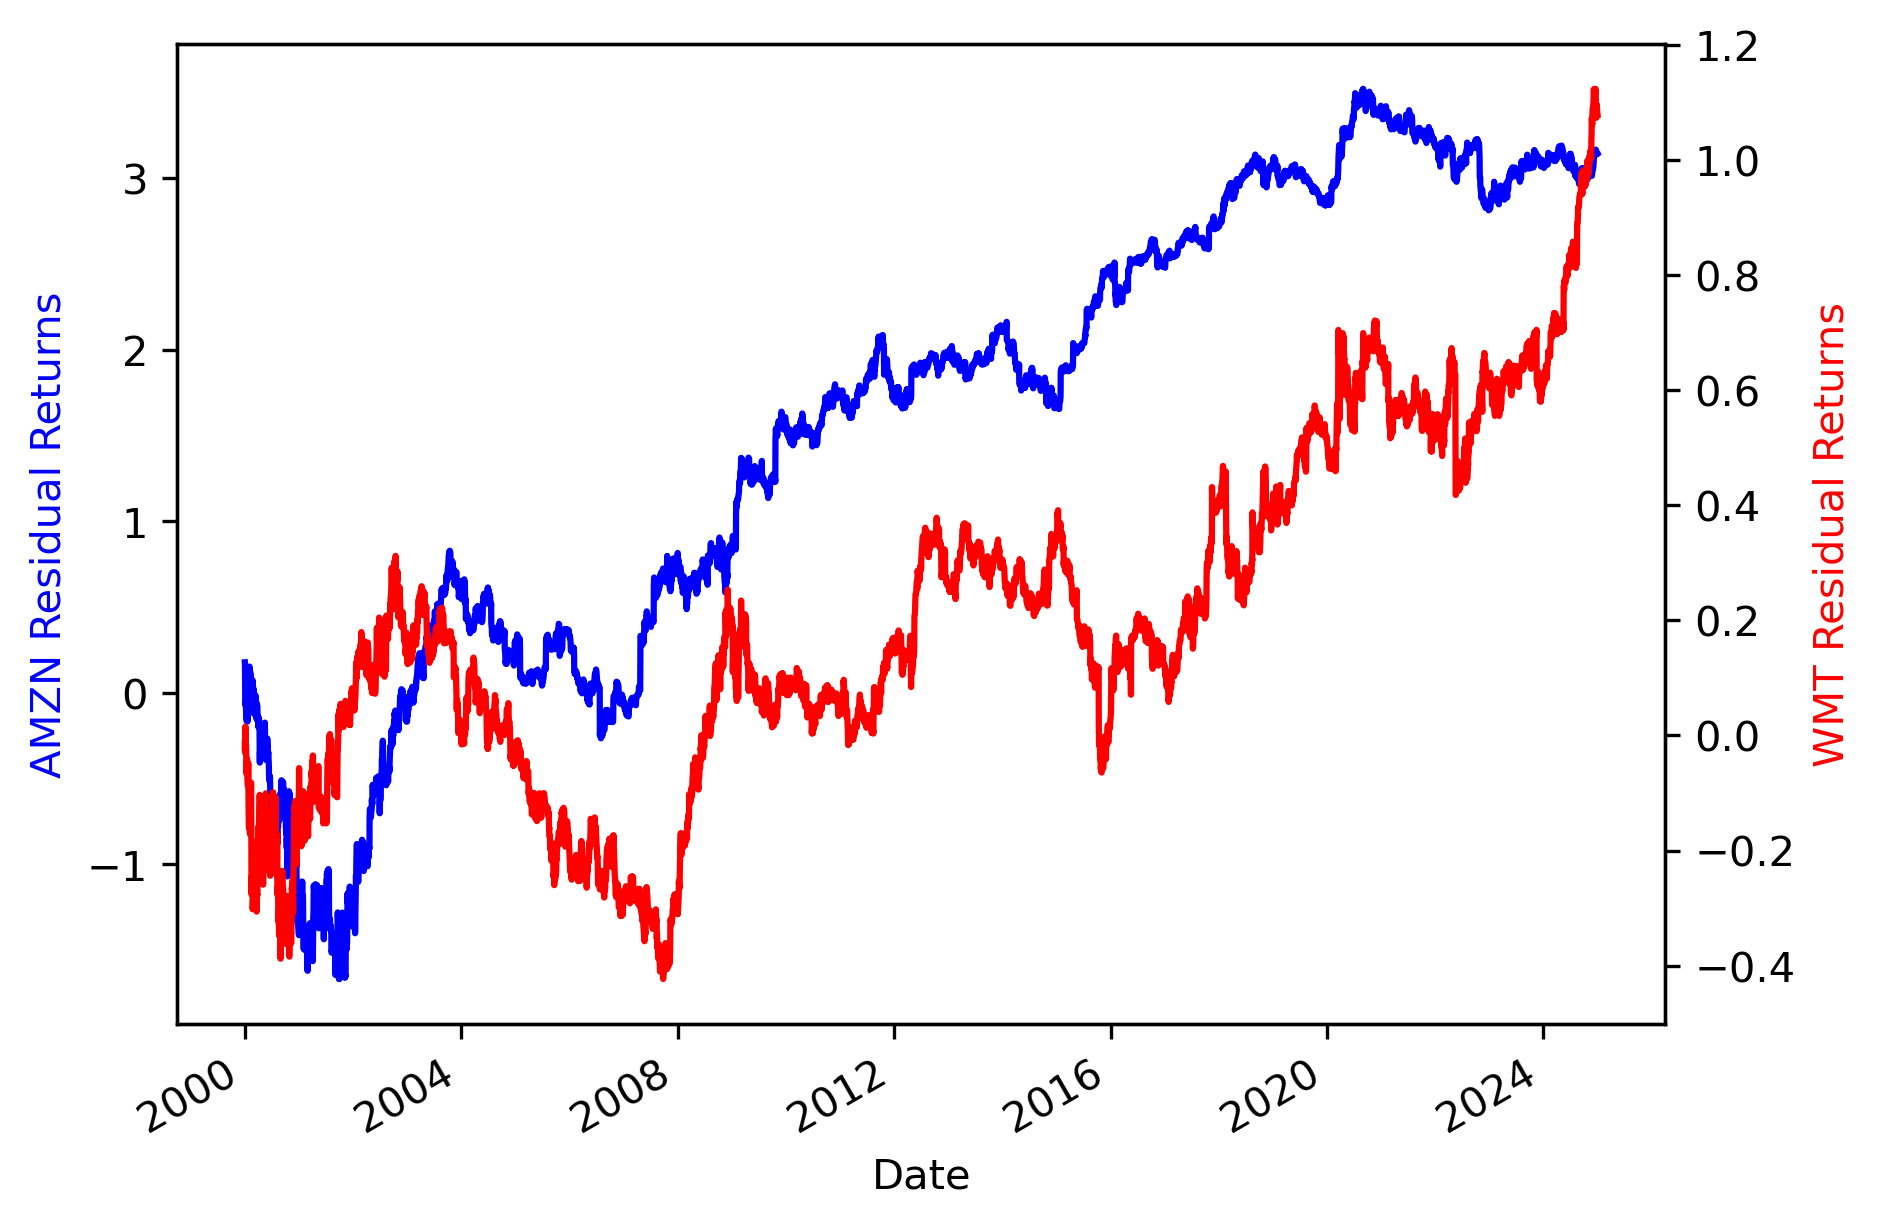

In [55]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# AMZN Residual Returns
res_returns['AMZN'].cumsum().plot(color = 'blue', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'AMZN Residual Returns', 
    color='blue'
    )

# WMT Residual Returns
ax2 = ax1.twinx()

res_returns['WMT'].cumsum().plot(color = 'red', ax = ax2)
ax2.set_ylabel(
    'WMT Residual Returns', 
    color='red'
    )

plt.show()

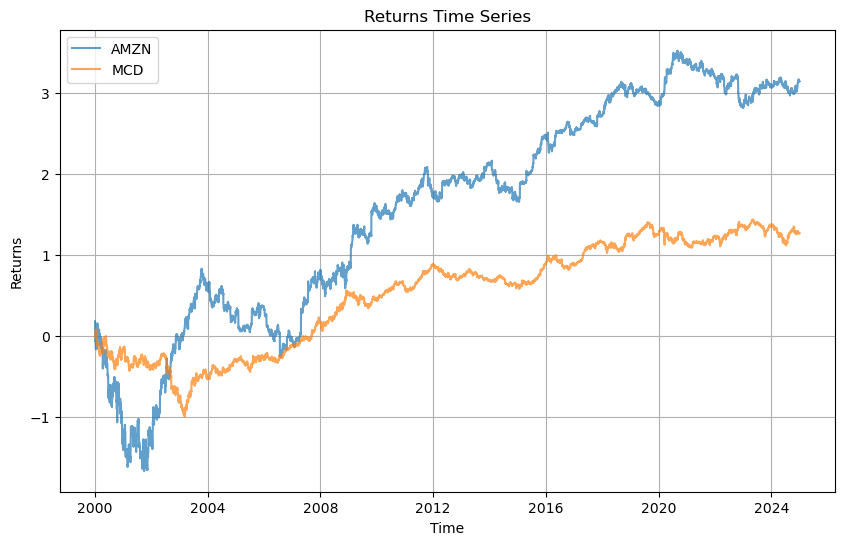

In [58]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(res_returns[['AMZN', 'MCD']].cumsum(), label=res_returns[['AMZN', 'MCD']].cumsum().columns, alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.grid()
plt.show()

In [59]:
# Before 2020: all data up to 2019-12-31
corr_before_2020 = res_returns['AMZN'].loc[:'2009-12-31'].corr(
    res_returns['WMT'].loc[:'2019-12-31'])

# After 2020: all data from 2020-01-01 onwards
corr_after_2020 = res_returns['AMZN'].loc['2010-01-01':].corr(
    res_returns['WMT'].loc['2020-01-01':])

print(f"The correlation between AMZN and WMT before 2010: {corr_before_2020}")
print(f"The correlation between AMZN and WMT after 2010: {corr_after_2020}")

The correlation between AMZN and WMT before 2010: -0.059636975671392096
The correlation between AMZN and WMT after 2010: 0.036817573957001117


In [68]:
# Calculate Rolling Correlation
rolling_corr_252d = res_returns['AMZN'].rolling(window=252).corr(res_returns['WMT'])

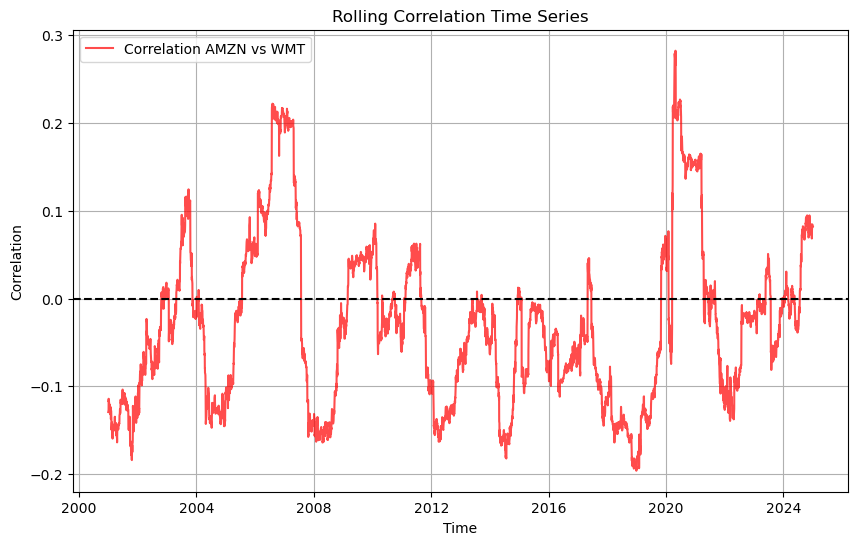

In [69]:
# Create the Plot
plt.figure(figsize=(10, 6))
plt.plot(rolling_corr_252d, label='Correlation AMZN vs WMT', color='red', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Rolling Correlation Time Series')
plt.xlabel('Time')
plt.ylabel('Correlation')
plt.legend()
plt.grid()

# Show
plt.show()

In [70]:
def portfolio_variance(
    weights, 
    returns
):
    weights = np.array(weights)
    if isinstance(returns, pd.DataFrame):
        returns = returns.values
    
    cov_matrix = np.cov(returns.T)  # covariance matrix
    port_var = weights.T @ cov_matrix @ weights
    return port_var

In [71]:
# Create the portfolio
portfolio_df = df_returns[['AMZN', 'WMT']]
weights = [0.5, 0.5]

port_var = portfolio_variance(
    weights,
    portfolio_df.mul(100)
)

print(f'Portfolio Variance: {port_var:.4f}')

Portfolio Variance: 3.4210


In [72]:
# Define the function for the rolling portfolio variance
def rolling_portfolio_variance(
    returns_df,
    weights,
    window=252
):
    weights = np.array(weights)

    rolling_vars = []
    index = returns_df.index

    for i in range(window - 1, len(returns_df)):
        window_returns = returns_df.iloc[i - window + 1 : i + 1]
        cov_matrix = np.cov(window_returns.T)
        var = weights.T @ cov_matrix @ weights
        rolling_vars.append(var)

    result = pd.Series([np.nan] * (window - 1) + rolling_vars, index=index)
    return result


In [75]:
# Calculate the Rolling Variance
rolling_var = rolling_portfolio_variance(portfolio_df, weights)
rolling_var = rolling_var * 100
rolling_var.name = 'rolling_var'

rolling_var.dropna()

2001-01-02    0.134118
2001-01-03    0.143215
2001-01-04    0.142636
2001-01-05    0.143371
2001-01-08    0.141553
                ...   
2024-12-24    0.012740
2024-12-26    0.012750
2024-12-27    0.012842
2024-12-30    0.012910
2024-12-31    0.012916
Name: rolling_var, Length: 6037, dtype: float64

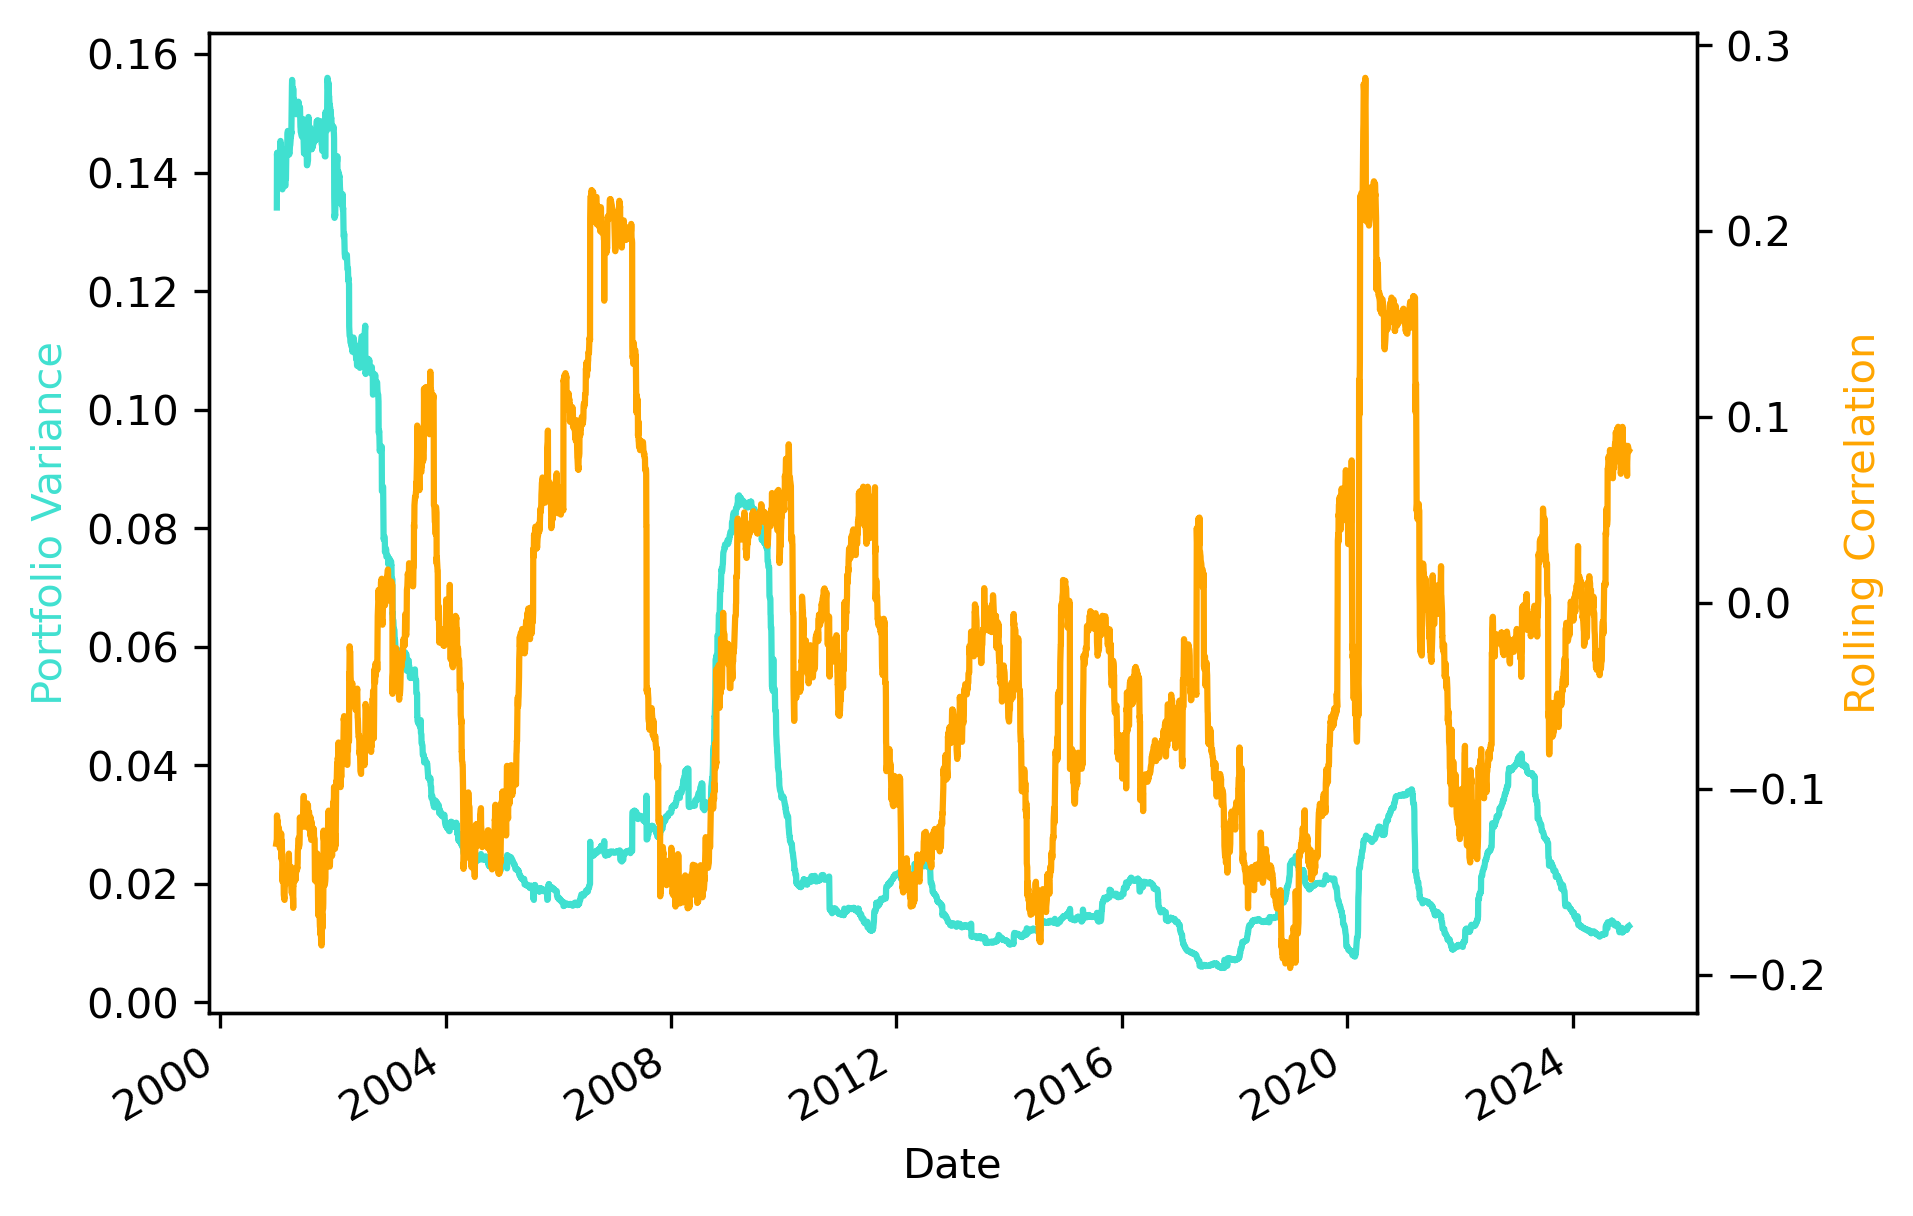

In [76]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Portfolio Variance
rolling_var.dropna().plot(color = 'turquoise', ax = ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Portfolio Variance', 
    color='turquoise'
    )

# Rolling Correlation
ax2 = ax1.twinx()

rolling_corr_252d.plot(color = 'orange', ax = ax2)
ax2.set_ylabel(
    'Rolling Correlation', 
    color='orange'
    )

plt.show()